# 1 Synaptic plasticity  and learning in SNN – D7046E @ LTU.SE

Both artificial neural networks (ANNs) and spiking neural networks (SNNs) can be optimized with gradient based learning using the back-propagation algorithm, which you are familiar with from the first ANN exercise. This paper describes one way to do that with SNNs (optional reading): [Training Deep Spiking Neural Networks Using Backpropagation](https://www.frontiersin.org/articles/10.3389/fnins.2016.00508/full).

However, this is not how brains function. The flexible adaptation and learning capabilities of brains emerge from plasticity mechanisms at the synapse and neuron level that are essentialy *local*. This means that the adaptation of neurons and synapses mainly depend on the relative timing and statistics of pre- and postsynaptic spikes. This concept is called *spike timing dependent plasticity* (STDP).

In this exercise you will perform simulation experiments with the STDP learning rule for excitatory synapses introduced in the lectures. The particular STDP model that you will investigate is desceribed in [Neuronal Dynamics, 19.2.2 Pair-based Models of STDP](https://neuronaldynamics.epfl.ch/online/Ch19.S2.html). Observe that this model does not apply to inhibitory synapses, which have constant weights in this exercise. You will also use the leaky integrate-and-fire (LIF) model of spiking neurons that you are familiar with from the first SNN exercise.

![STDP model](https://neuronaldynamics.epfl.ch/online/x596.png)

The basic idea of the pair-based STDP model is illustrated in the figure above. A synapse on a neuron receives a presynaptic spike at time $t^f_i$ and the neuron fires a postsynaptic spike at $t^f_j$. When this happens, the weight of the synapse changes by a relative amount $\Delta w_{ij}/w_{ij}$ that depends on the relative timing of spikes, $t^f_j-t^f_i$, as illustrated by the experimental results in the figure. The rationale of this is quite:

- If the presynaptic spike happens just before the postsynaptic spike there is a cause and effect (causality). The synapse contributes to firing of a spike. In this case the synapse weight is increased (strengthened).
- If the presynaptic spike happens just after the postsynaptic spike the latter was fired due to inputs on other synapses and there is *no causal effect*. In this case the synapse weight is decreased (weakened), but not below zero since it remains an excitatory synapse.

In general, correlation-based learning of this type is called [Hebbian Learning](https://neuronaldynamics.epfl.ch/online/Ch19.S1.html).

The local nature of STDP is key for high energy efficiency. The long-range propagation of derivatives in backpropagation is costly. These aspects have important [carbon emission and environmental consequences](https://www.forbes.com/sites/robtoews/2020/06/17/deep-learnings-climate-change-problem). Neuromorphic computing based on SNNs and STDP [offer an interesting alternative](https://tube.switch.ch/videos/db393d1d).

# 2 Basic SNN Simulator

The following basic SNN simulator is familiar from the first SNN exercise. This code has been extended with a neuron type implementing pair-based STDP synapses, as described in [Neuronal Dynamics, 19.2.2 Pair-based Models of STDP](https://neuronaldynamics.epfl.ch/online/Ch19.S2.html).

## 2.1 Libraries and generic functions

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from IPython.display import clear_output
#from IPython.core.debugger import set_trace # Activates debugging features

def rasterplot(ax, x, y, x_label, y_label):
# Function used to plot spike times
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x, y, marker='|')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

## 2.2 Neuron constructors

In [2]:
def lif_neuron(I_inject, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=90e6, tau_m=30e-3):
    # LIF neuron with a constant injection current
    return {
        'type'    : 'lif',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'E_L'     : E_L,                       # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'I_inj'   : I_inject,                  # Injection current [Ampere]
    }

def lif_syn_neuron(num_synapses, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=90e6, tau_m=30e-3, I_inject=0, tau_syn=50e-3):
    # LIF neuron with dynamic synapses
    n = lif_neuron(I_inject, E_L, u_reset, u_thres, R, tau_m)
    n['tau_syn'] = tau_syn                     # Synapse time constant [second] (can also be an array)
    n['I_syn']   = np.zeros(num_synapses)      # Postsynaptic currents [Ampere]
    n['w_syn']   = np.zeros(num_synapses)      # Synaptic weights [Ampere]
    n['type']    = 'lif_syn'
    return n

def lif_stdp_neuron(num_synapses, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=90e6, tau_m=30e-3, I_inject=0,
                    tau_syn=50e-3, tau_pls=20e-3, tau_mns=20e-3, w_max=1e-9, w_min=1e-12, gamma=1):
    # LIF neuron with dynamic synapses and pair-based STDP
    n = lif_syn_neuron(num_synapses, E_L, u_reset, u_thres, R, tau_m, I_inject, tau_syn)
    n['x_pre']   = np.zeros(num_synapses)      # STDP trace of presynaptic spikes
    n['y_pst']   = 0                           # STDP trace of postsynaptic spikes (scalar, one neuron)
    n['tau_pls'] = tau_pls                     # STDP trace time constant [second] (can also be an array)
    n['tau_mns'] = tau_mns                     # STDP trace time constant [second] (can also be an array)
    n['w_max']   = w_max                       # Largest allowed value of synapse conductance
    n['w_min']   = w_min                       # Lowest allowed value of synapse conductance
    n['gamma']   = gamma                       # Learning rate parameter with soft bounds (w_min,w_max)
    n['type']    = 'lif_stdp'
    return n

def poisson_neuron(spike_frequency):
    # Random spike generator with Poisson distributed spike time intervals, see Section 7.2.1 in the book
    return {
        'type'      : 'poisson',
        'frequency' : spike_frequency          # Average spiking frequency
    }

def spike_generator(spike_times):
    # Generates spikes at time points defined by the sorted list 'spike_t'
    return {
        'type'      : 'generator',
        'spike_t'   : spike_times              # Array of spike times, separated by at least dt
    }

## 2.3 Network update functions

In [3]:
def integrate(dt, t, neurons):
    # Integrate the membrane potential, postsynaptic currents etc one timestep dt
    for n in neurons:
        if n['type'] == 'lif':
            # Integrate membrane potential
            dudt = (n['E_L'] - n['u'] + n['R']*n['I_inj']) / n['tau_m']
            n['u'] += dt*dudt
        elif n['type'] in ['lif_syn','lif_stdp']:
            # Integrate array of postsynaptic currents, one current for each synapse
            didt = np.divide(-n['I_syn'], n['tau_syn'])
            n['I_syn'] += dt*didt
            # Integrate membrane potential
            dudt = (n['E_L'] - n['u'] + n['R']*(n['I_inj']+sum(n['I_syn']))) / n['tau_m']
            n['u'] += dt*dudt
            # Integrate local traces for pair-based plasticity
            if n['type'] == 'lif_stdp':
                n['x_pre'] -= dt*np.divide(n['x_pre'], n['tau_pls'])       # Eq 19.12
                n['y_pst'] -= dt*np.divide(n['y_pst'], n['tau_mns'])       # Eq 19.13
            
def spikegen(dt, t, neurons):
    # Implements the non-linear spike generation mechanism
    spikes = []
    for i,n in enumerate(neurons):
        if n['type'] in ['lif','lif_syn','lif_stdp']:
            if n['u'] > n['u_thres']:
                n['u'] = n['u_reset']
                spikes.append(i)
        elif n['type'] == 'poisson':
            if np.random.rand() < dt*n['frequency']:
                spikes.append(i)
        elif n['type'] == 'generator':
            j = np.searchsorted(n['spike_t'], t, side='right')
            if j>0 and t-n['spike_t'][j-1]<dt:
                spikes.append(i)
                
    return spikes

def update(dt, t, neurons, connections):
    # Update the state of a spiking neural network.
    # Refer to Exercise 3 for a reminder about how to set up connections between neurons.
    integrate(dt, t, neurons)
    spikes = spikegen(dt, t, neurons)

    # Update weights and STDP trace for each postsynaptic spike
    for spike in spikes:
        n = neurons[spike]
        if n['type'] in ['lif_stdp']:
            n['y_pst'] += 1                                         # Eq 19.13
            for i,w in enumerate(n['w_syn']):
                if w > 0:                                           # Excitatory synapses
                    Aplus = n['gamma']*(n['w_max'] - n['w_syn'][i]) # Eq 19.4
                    n['w_syn'][i] += dt*Aplus*n['x_pre'][i]         # Eq 19.14
    
    # Update synapse currents, weights and STDP traces for each presynaptic spike
    for (post, syn, pre) in connections:
        for spike in spikes:
            if spike == pre:
                n = neurons[post]
                
                if n['type'] not in ['lif_syn', 'lif_stdp']:
                    print('Error: Spike sent to neuron type without synapses')
                
                # Update synapse currents
                if n['type'] in ['lif_syn','lif_stdp']:
                    n['I_syn'][syn] += n['w_syn'][syn]
                    
                # Update STDP trace and weight
                if n['type'] in ['lif_stdp']:
                    n['x_pre'][syn] += 1                                   # Eq 19.12
                    if n['w_syn'][syn] > 0:                                # Excitatory synapses
                        Aminus = n['gamma']*(n['w_min'] - n['w_syn'][syn]) # Eq 19.4
                        n['w_syn'][syn] += dt*Aminus*n['y_pst']            # Eq 19.14
    
    return spikes

# 3 Tasks

## 3.1 Synaptic plasticity experiment

**Task 1:** Connect a poisson neuron with 20 Hz spike frequency to one STDP synapse on a LIF neuron. Set the soft bounds on the weight to (w_min=0, w_max=300e-12) and the learning rate to a high value (eg gamma=10) to speed up the weight changes. Set the initial weight of the STDP synapse to 200e-12 and simulate the resulting two-neuron network. Prepare a plot like Figure 19.6 in [Section 19.2](https://neuronaldynamics.epfl.ch/online/Ch19.S2.html) and study the relation between the weight updates and the pre- and postsynaptic spike times. Why does the weight decrease at certain times, and increase at other times?

**Answer:** The weight increases when a presynaptic spike happens before a postsynaptic spike and decreases when a postsynaptic spike happens before a pre synaptic spike.

### 3.1.1 Define neurons and connections

In [4]:
# 20 Hz poisson neuron
n0 = poisson_neuron(20)

# LIF neuron with one STDP synapse
n_stdp = lif_stdp_neuron(1,w_min=0, w_max=300e-12, gamma=10)
n_stdp['w_syn'][0] = 200e-12

# Neuron population
neurons = [n0, n_stdp]

# Connect n0 to n_stdp
connections = [[1, 0, 0]]   # [post,syn,pre], see former SNN exercise

# Init time coordinate and stepsize
t = 0
dt = 1e-4

### 3.1.2 Simulate the network and plot results

The code below can be executed multiple times to advance the simulation one second

14
12


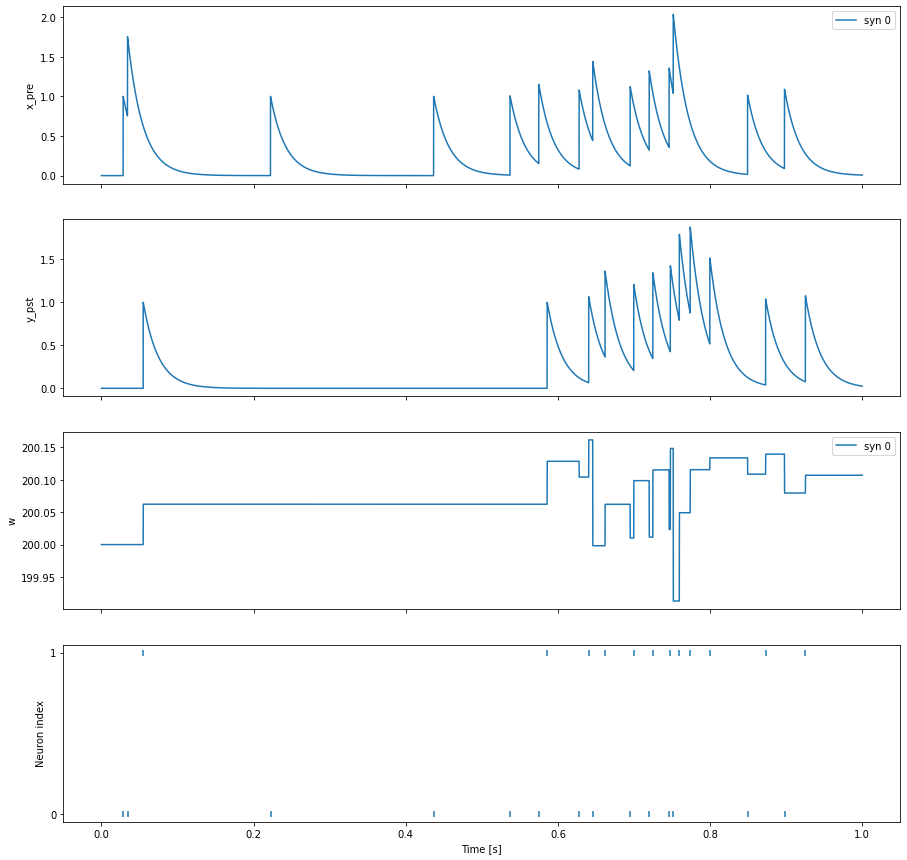

In [5]:
t0 = t
tv = []
x = []
y = []
w = []
t_spike = []
n_spike = []

while t < t0+1:

    spikes = update(dt, t, neurons, connections)
    
    # Store membrane potentials needed for plotting/analysis
    tv.append(t)
    x.append(list(n_stdp['x_pre']))
    y.append(n_stdp['y_pst'])
    w.append(list(n_stdp['w_syn']/1e-12))
    
    # Store spikes needed for plotting/analysis
    if len(spikes)>0:
        for s in spikes:
            t_spike.append(t)
            n_spike.append(s)

    # Timestep completed
    t += dt

plt.rcParams['figure.figsize'] = [15, 15]
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True)
ax1.plot(tv,x); ax1.set_ylabel('x_pre'); ax1.legend(['syn 0'])
ax2.plot(tv,y); ax2.set_ylabel('y_pst')
ax3.plot(tv,w); ax3.set_ylabel('w'); ax3.legend(['syn 0'])
rasterplot(ax4, t_spike, n_spike,'Time [s]','Neuron index')
#fig.savefig('stdp_example.pdf',format='pdf')

print(n_spike.count(0))
print(n_spike.count(1))

**Task 2:** What happens if you set the initial weight of the STDP synapse to 150e-12 and simulate the resulting network? Why is the behaviour different compared to the result obtained in Task 1? (Hint: Estimate the number of postsynaptic spikes per second of simulation time and compare that with the presynaptic spikerate)

**Answer:** The postsynaptic current is increasing at a slower rate since the weight is lower this means that the stdp synapse wont spike as often. 

In [6]:
# 20 Hz poisson neuron
n0 = poisson_neuron(20)

# LIF neuron with one STDP synapse
n_stdp = lif_stdp_neuron(1,w_min=0, w_max=300e-12, gamma=10)
n_stdp['w_syn'][0] = 150e-12

# Neuron population
neurons = [n0, n_stdp]

# Connect n0 to n_stdp
connections = [[1, 0, 0]]   # [post,syn,pre], see former SNN exercise

# Init time coordinate and stepsize
t = 0
dt = 1e-4

17
7


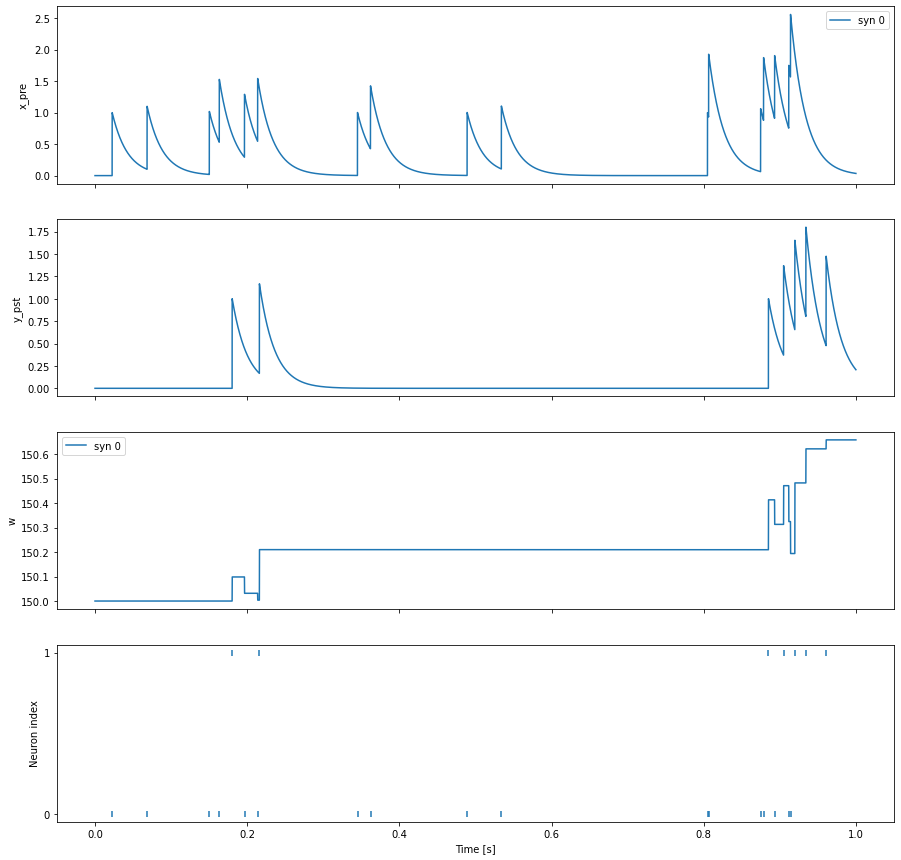

In [7]:

# Code for Task 2
t0 = t
tv = []
x = []
y = []
w = []
t_spike = []
n_spike = []

while t < t0+1:

    spikes = update(dt, t, neurons, connections)
    
    # Store membrane potentials needed for plotting/analysis
    tv.append(t)
    x.append(list(n_stdp['x_pre']))
    y.append(n_stdp['y_pst'])
    w.append(list(n_stdp['w_syn']/1e-12))
    
    # Store spikes needed for plotting/analysis
    if len(spikes)>0:
        for s in spikes:
            t_spike.append(t)
            n_spike.append(s)

    # Timestep completed
    t += dt

plt.rcParams['figure.figsize'] = [15, 15]
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True)
ax1.plot(tv,x); ax1.set_ylabel('x_pre'); ax1.legend(['syn 0'])
ax2.plot(tv,y); ax2.set_ylabel('y_pst')
ax3.plot(tv,w); ax3.set_ylabel('w'); ax3.legend(['syn 0'])
rasterplot(ax4, t_spike, n_spike,'Time [s]','Neuron index')
#fig.savefig('stdp_example.pdf',format='pdf')

print(n_spike.count(0))
print(n_spike.count(1))


**Task 3:** What happens if you set the initial weight of the STDP synapse to 300e-12 and simulate the resulting network? Why is the behaviour different compared to the result obtained in Task 1 and Task 2?

**Answer:** When we have more postsynaptic spikes than the presynaptic thre will be more post before pre which decreases the synaptic weights.

In [8]:

# Code for Task 3
# 20 Hz poisson neuron
n0 = poisson_neuron(20)

# LIF neuron with one STDP synapse
n_stdp = lif_stdp_neuron(1,w_min=0, w_max=300e-12, gamma=10)
n_stdp['w_syn'][0] = 300e-12

# Neuron population
neurons = [n0, n_stdp]

# Connect n0 to n_stdp
connections = [[1, 0, 0]]   # [post,syn,pre], see former SNN exercise

# Init time coordinate and stepsize
t = 0
dt = 1e-4


21
43


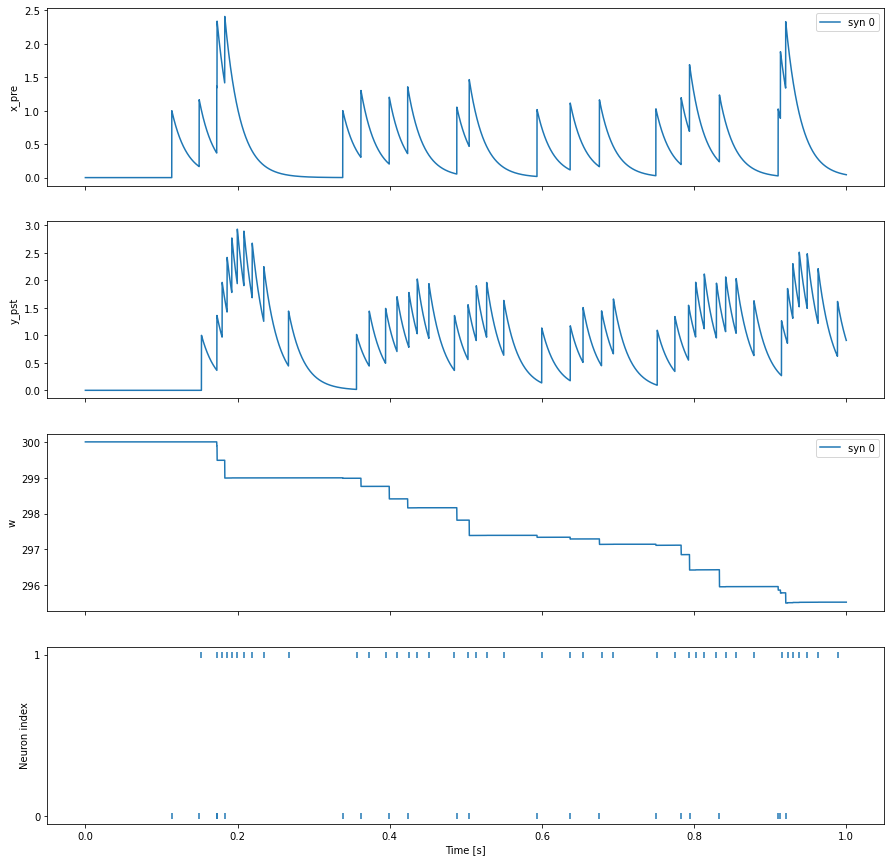

In [9]:
# Code for Task 2
t0 = t
tv = []
x = []
y = []
w = []
t_spike = []
n_spike = []

while t < t0+1:

    spikes = update(dt, t, neurons, connections)
    
    # Store membrane potentials needed for plotting/analysis
    tv.append(t)
    x.append(list(n_stdp['x_pre']))
    y.append(n_stdp['y_pst'])
    w.append(list(n_stdp['w_syn']/1e-12))
    
    # Store spikes needed for plotting/analysis
    if len(spikes)>0:
        for s in spikes:
            t_spike.append(t)
            n_spike.append(s)

    # Timestep completed
    t += dt

plt.rcParams['figure.figsize'] = [15, 15]
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True)
ax1.plot(tv,x); ax1.set_ylabel('x_pre'); ax1.legend(['syn 0'])
ax2.plot(tv,y); ax2.set_ylabel('y_pst')
ax3.plot(tv,w); ax3.set_ylabel('w'); ax3.legend(['syn 0'])
rasterplot(ax4, t_spike, n_spike,'Time [s]','Neuron index')
#fig.savefig('stdp_example.pdf',format='pdf')

print(n_spike.count(0))
print(n_spike.count(1))

**Task 4:** Describe the results in Tasks 1-3 in terms of Hebbian Learning.

*Hint: The weight influences the spikerate of the postsynaptic neuron. Consider the effect of different spikerates of the postsynaptic neuron on the relative timing of pre- and postsynaptic spikes (on the average).*

**Answer:** Hebbian learning ... In Task # ... when ...


**Task 5:** Describe the relation between this implementation of STDP and the concept illustrated in [Figure 19.4F](https://neuronaldynamics.epfl.ch/online/Ch19.S1.html) in Neuronal Dynamics. You have to study the pair-based STDP equations and related figures/text in the book to understand the relation.

**Answer:** This implementation is based on equations ..., which ...

## 3.2 Learning of MNIST digits and classification

SNNs with STDP can adapt to firing patterns in the stimulus. The tasks above illustrates that at the single synapse and neuron level.

With multiple cells, and competition between the excitatory cells via mutual/lateral inhibition, the different excitatory cells adapt to different stimuli. Such networks can perform clustering of stimuli via activation of different cell assemblies, and forms a basis for [decision making networks](https://neuronaldynamics.epfl.ch/online/Ch16.html).

A network of this kind can for example be used to classify inputs, or to learn [visual receptive fields](https://doi.org/10.1523/JNEUROSCI.4188-12.2013). In this task you will implement some parts of the MNIST classification network presented in the paper [unsupervised learning of digit recognition using spike-timing-dependent plasticity](https://doi.org/10.3389/fncom.2015.00099) and study the STDP of synapses on two excitatory cells when digits from the MNIST dataset are presented to the network.

![Network](https://www.frontiersin.org/files/Articles/149773/fncom-09-00099-r4/image_m/fncom-09-00099-g001.jpg)

### 3.2.1 Load MNIST samples

You will only consider two digits and two excitatory cells to reduce the simulation time and complexity of the task (see the [paper](https://doi.org/10.3389/fncom.2015.00099) for complete results).

In [ ]:
def plot_digit(plt, data):
# Display MNIST images
    data = data.view(28,28)
    plt.imshow(data, cmap='gray')

mnist_train = datasets.MNIST('./', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=1000, shuffle=False)
images, labels = next(iter(train_loader))

# Extract 10 training samples for two classes of digits
im3 = images[labels==3][0:10]
im5 = images[labels==5][0:10]
print('%d training inputs loaded' %(len(im3)+len(im5)))
del images, labels, mnist_train, train_loader

# Normalization of inputs
nf = (im3.sum() + im5.sum())/(len(im3)+len(im5))
for i in range(10):
    im3[i] = im3[i]*nf/im3[i].sum()
    im5[i] = im5[i]*nf/im5[i].sum()

# Plot stimuli intensities
plt.rcParams['figure.figsize'] = [16, 4]
fig, axs = plt.subplots(2, 10,sharey=True)
for i in range(10):
    plot_digit(axs[0, i], im3[i])
    plot_digit(axs[1, i], im5[i])
plt.show()

### 3.2.2 Define neuron populations and connections

There are three neuron populations in the achitecture described in the paper, as illustrated above:

- Input: 28x28 randomly spiking neurons with pixel-intensity dependent spike frequencies.
- Excitatory neurons: A number of excitatory LIF neurons. 2 in this exercise.
- Inhibitory neurons: Here we will **simplify** this part and use two inhibitory synapses instead.

Each excitatory neuron recives input from all 28x28 input neurons (all-to-all connectivity) via plastic STDP synapses. The STDP synapse weights are initialized randomly. The excitatory neurons inhibit eachother via one inhibitory synapse on each neuron, thus the name *lateral inhibition*. This simplification is possible in SNNs (but not in biology, since excitatory neurons only form excitatory synapses on the target dendrites).

In [ ]:
N_pixls = 28
N_input = N_pixls*N_pixls

neurons = []
connections = []

# Create input neurons, frequencies will be set later
for i in range(N_input):
    neurons.append(poisson_neuron(0))
    
# Create two excitatory neurons
e1 = lif_stdp_neuron(N_input+1, w_min=0, w_max=10e-12)
e2 = lif_stdp_neuron(N_input+1, w_min=0, w_max=10e-12)
neurons.append(e1)
neurons.append(e2)
I_e1 = N_input
I_e2 = N_input+1

# Define excitatory STDP synapses for the inputs
for j in range(N_input):
    e1['w_syn'][j] = 2e-12*(0.1 + 0.9*np.random.rand())
    e2['w_syn'][j] = 2e-12*(0.1 + 0.9*np.random.rand())
    connections.append([I_e1,j,j]) # [post,syn,pre], see Exercise 3 for details
    connections.append([I_e2,j,j]) # [post,syn,pre]

# Lateral inhibition (neglecting Dale's law to simplify the exercise)
I_inhib = N_input
e1['w_syn'][I_inhib] = -1e-12
e2['w_syn'][I_inhib] = -1e-12
connections.append([I_e1,I_inhib,I_e2])
connections.append([I_e2,I_inhib,I_e1])

In [ ]:
def reset_input_frequencies(neurons):
# Reset frequencies of input neurons to 0 Hz
    for i in range(N_pixls):
        for j in range(N_pixls):
            neurons[i*N_pixls+j]['frequency'] = 0

def set_input_frequencies(neurons, image):
# Convert pixel intensities to spikerates of random (Poisson) neurons
    for i in range(N_pixls):
        for j in range(N_pixls):
            neurons[i*N_pixls+j]['frequency'] = 5 + 55*image[i][j] # 5-60 Hz
            
def spikerate_filter(spikerate, spikecount, simtime, alpha):
# Low-pass filter for estimation of spikerate
    if spikerate > 0:
        spikerate = alpha*spikerate + (1-alpha)*spikecount/simtime
    else:
        spikerate = spikecount/simtime
    return spikerate

def plot_neuron_weights(n):
# Plot the input weights of an excitatory neuron (with STDP synapses)
    plt.rcParams['figure.figsize'] = [10, 3]
    fig,(ax1,ax2) = plt.subplots(1,2)
    img = np.zeros((N_pixls,N_pixls))
    for i in range(N_pixls):
        for j in range(N_pixls):
            img[i][j] = n['w_syn'][i*N_pixls+j]/1e-12
    ax1.imshow(img, cmap='viridis')
    ax2.hist(np.hstack(img))
    ax2.set_xlabel('Weight [pA]')
    ax2.set_ylabel('No. synapses')
    plt.show()

In [ ]:
# Reset the simulation time
t = 0
dt = 5e-4
simtime = 0.35
rsttime = 0.15

# Reset spikerate variables
e1_spikerate = -1
e2_spikerate = -1

### 3.2.3 Supervised training of the network

Lateral inhibition plays a key role for the learning (clustering) capabilities of the network. Here you will manually control the inhibition in a supervised fashion, and investigate the resulting weights of the excitatory cells.

**Task 6:** Modify the weights of the inhibitory synapses on the two excitatory neurons e1 and e2 at the indicated positions in the code below, so that e1 is inhibited when a training sample from one of the two classes of digits is presented, and vice versa. Run 50 training iterations and compare your result with the result already provided below. What values of the inhibitory weights enables the two neurons to adapt to the two classes of stimuli? Describe what happened for different values of the inhibitory weights.

**Answer:** With a value of ...

**Task 7:** Explain the result obtained in Task 6 in terms of the experience gained from Tasks 1-5. Why does STDP produce this result, how can the neuron weights successfully adapt to the stimuli?

**Answer:** In ...

In [ ]:
from __future__ import print_function   # Python 2.X support for print function, not needed in Python 3.X

# Speed up learning a bit
e1['gamma'] = 5
e2['gamma'] = 5

for iterations in range(50): # Training iterations

    # Start time
    t0 = t
    
    # Spike counts of e1 and e2
    e1_count = 0
    e2_count = 0
    
    # Sample a different digit every second iteration
    stimuli = []
    if iterations % 2 == 0:
        stimuli = im3[int(10*np.random.rand())][0]
        ##############################################################################
        # INSERT SUPERVISION SIGNAL HERE, INHIBIT ONE OF THE TWO STDP NEURONS
        e1['w_syn'][I_inhib] = ...
        e2['w_syn'][I_inhib] = ...
        ##############################################################################
    else:
        stimuli = im5[int(10*np.random.rand())][0]
        ##############################################################################
        # INSERT SUPERVISION SIGNAL HERE, INHIBIT ONE OF THE TWO STDP NEURONS
        e1['w_syn'][I_inhib] = ...
        e2['w_syn'][I_inhib] = ...
        ##############################################################################
    set_input_frequencies(neurons, stimuli)
    
    # Simulate the network
    while t < t0+simtime:
    
        # Update network, including STDP
        spikes = update(dt, t, neurons, connections)
        
        # Count number of spikes from e1 and e2
        e1_count += spikes.count(I_e1)
        e2_count += spikes.count(I_e2)
        
        # Timestep completed
        t += dt
        print('\r t = %fs (%d%%)' % (t, 100*(t-t0)/(simtime+rsttime)), end='')

    # Let neurons and synapses rest before the next stimuli 
    reset_input_frequencies(neurons)
    while t < t0+simtime+rsttime:
        spikes = update(dt, t, neurons, connections)
        e1_count += spikes.count(I_e1)
        e2_count += spikes.count(I_e2)
        t += dt
        print('\r t = %fs (%d%%)' % (t, 100*(t-t0)/(simtime+rsttime)), end='')

    # Refresh the plots
    clear_output()
    print('\nStimuli:')
    plot_digit(plt,stimuli)
    plt.show()
    print('Excitatory cell e1 spike count: %d, and weight distribution after %d seconds:' % (e1_count,t))
    plot_neuron_weights(e1)
    print('Excitatory cell e2 spike count: %d, and weight distribution after %d seconds:' % (e2_count,t))
    plot_neuron_weights(e2)
    plt.show()

**Task 8:** Next, switch off learning and adjust the lateral inhibition so that your network can classify samples in your training set. How is the predicted class determined? Investigate if you can get 100% correct classification on the training set. (You do not have to consider a validation and test set in this exercise)

**Answer:** The predicted class is determined by ... and X out of the Y samples are correctly classified with inhibitory weights ...

In [ ]:
e1['gamma'] = 0
e2['gamma'] = 0

e1['w_syn'][I_inhib] = ...
e2['w_syn'][I_inhib] = ...

for iterations in range(20):

...

### 3.2.4 Optional task: Unsupervised learning

In principle, it is possible to adapt the inhibition of e1 and e2 during training, so that the synapses self-organize via STDP in a similar way as in Section 3.2.3 but without any supervision signal. This requires homeostatic regulation of the e1 and e2 spikerates (described in the lectures and the papers referenced above). The trick here is to establish the right balance between lateral inhibition and spikerate regulation, so that the excitatory cells are mutually activated and deactivated when different stimuli are presented.

Can you solve this *challenge*? Sample code is provided below

In [ ]:
simtime = 0.35  # seconds, period when stimuli is presented
rsttime = 0.15  # seconds, period when no stimuli is presented

for iterations in range(2):

    t0 = t

    e1_count = 0
    e2_count = 0
    
    # Draw a different digit every second iteration
    stimuli = []
    if iterations % 2 == 0:
        stimuli = im5[int(10*np.random.rand())][0]
    else:
        stimuli = im3[int(10*np.random.rand())][0]
    set_input_frequencies(neurons, stimuli)
    
    # Stimulate the network
    while t < t0+simtime:
    
        # Update network, including STDP
        spikes = update(dt, t, neurons, connections)
        
        # Count number of spikes from e1 and e2
        e1_count += spikes.count(N_input+0)
        e2_count += spikes.count(N_input+1)
        
        # Timestep completed
        t += dt
        print('\r t = %fs (%d%%)' % (t, 100*(t-t0)/(simtime+rsttime)), end = '')

    # Homeostatic regulation of spikerate, update the spiking threshold of the excitatory neurons
    e1_spikerate = spikerate_filter(e1_spikerate, e1_count, simtime, 0.5)
    e2_spikerate = spikerate_filter(e2_spikerate, e2_count, simtime, 0.5)
    if e1_spikerate   ...
        e1['u_thres'] ...
    elif e2_spikerate ...
        e2['u_thres'] ...
        
    # Let neurons and synapses rest before the next stimuli 
    reset_input_frequencies(neurons)
    while t < t0+simtime+rsttime:
        spikes = update(dt, t, neurons, connections)
        e1_count += spikes.count(N_input+0)
        e2_count += spikes.count(N_input+1)
        t += dt
        print('\r t = %fs (%d%%)' % (t, 100*(t-t0)/(simtime+rsttime)), end = '')

    # Refresh the plots
    clear_output()
    print('\nStimuli:')
    plot_digit(plt,stimuli)
    plt.show()
    print('Excitatory cell e1 spike count: %d, and weight distribution:' % (e1_count))
    plot_neuron_weights(e1)
    print('Excitatory cell e2 spike count: %d, and weight distribution:' % (e2_count))
    plot_neuron_weights(e2)
    print('Spikerates of e1 and e2 are %1.1f Hz and %1.1f Hz, respectively.' % (e1_spikerate,e2_spikerate))
    print('Thresholds are %1.4f mV and %1.4f mV, respectively.' % (e1['u_thres'],e2['u_thres']))
    print('Inh weights are %1.2e pA and %1.2e pA, respectively.' % (e1['w_syn'][I_inhib],e2['w_syn'][I_inhib]))

# 4 Comment and further reading

In this exercise you have considered a tiny network of two neurons. In the paper considered as inspiration for this exercise the accuracy on the test set increases with the number of excitatory neurons in the population:

![MNIST test result](https://www.frontiersin.org/files/Articles/149773/fncom-09-00099-r4/image_m/fncom-09-00099-g002.jpg)

An interesting aspect is that the STDP learning rule is a local rule that does not depend on global gradients. The training protocol is also unsupervised up to the point where the activities of different neuron populations are linked to class labels. Tnus, this SNN solves an unsupervised clustering task. After clustering the inputs, a class label can be associated with neurons that are activated for one specific digit. The activity of the subset/population of neurons that tend to fire for one particular input class determine which class the input belongs to.

Similar accuracies can be obtained with SNN and ANN; [Spiking neural networks for handwritten digit recognition—Supervised learning and network optimization](https://doi.org/10.1016/j.neunet.2018.03.019)

There is more to learn about how different spike codes and learning architectures can be further developed to improve on these results, see for example: [Deep Learning With Spiking Neurons: Opportunities and Challenges](https://doi.org/10.3389/fnins.2018.00774)